In [277]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

In [278]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [279]:
s = ctl.TransferFunction.s

G = 0.025/(0.15560577*s**2 - 0.78893795*s + 1.0)
G

TransferFunction(array([0.025]), array([ 0.15560577, -0.78893795,  1.        ]))

In [280]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)

# CONVERTENDO PARA MATRIZ DE ESTADO

$\dot{x} = Ax + Bu$

$y = Cx + Du$

In [281]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(A)
display(B)
display(C)
display(D)

array([[ 5.0701073 , -6.42649691],
       [ 1.        ,  0.        ]])

array([[1.],
       [0.]])

array([[0.        , 0.16066242]])

array([[0.]])

# FORMAS CANÔNICAS

### VARIÁVEL DE FASE
Para obter a forma de variáveis de fase, realizamos as seguintes operações:
A = inv(P) * A * P; B = inv(P) * B; C = C * P; D = D, em que P é uma matriz
quadrada com elementos 1 ao longo da diagonal secundária e o restante dos
elementos nulos.

In [282]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

A, B, C, D = getVariaveisFase(G)
display(A)
display(B)
display(C)
display(D)

Matrix([
[               0,              1.0],
[-6.4264969094655, 5.07010729743505]])

Matrix([
[  0],
[1.0]])

Matrix([[0.160662422736638, 0]])

Matrix([[0]])

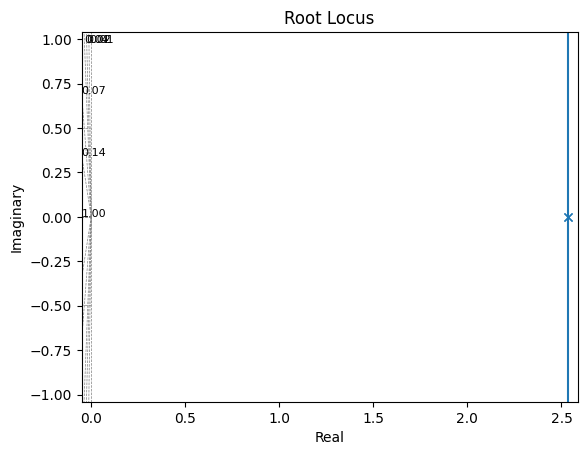

In [283]:
ctl.root_locus(G)
plt.show()

# REQUISITOS DO SISTEMA

In [284]:
Ts = 10
UP = 0.5

In [285]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.2154537619662468

In [286]:
Wn = 4/(zeta*Ts)
Wn

1.8565468356160075

In [287]:
s_desired = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_desired

-0.4 + 1.81294405673088*I

In [288]:
poles

array([2.53535764+0.j, 2.53474966+0.j])

In [289]:
s1 = sp.re(s_desired) + sp.im(s_desired)*sp.I
s2 = sp.re(s_desired) - sp.im(s_desired)*sp.I
s3 = -4
s4 = -4

s1, s2, s3, s4

(-0.4 + 1.81294405673088*I, -0.4 - 1.81294405673088*I, -4, -4)

In [290]:
s = sp.symbols('s')
I = sp.eye(2)
j = sp.I

c = sp.Matrix([[B, A*B]])
o = sp.Matrix([
    [C],
    [C*A],
])

rho   = sp.Matrix([[0, 1]])
rho_v = sp.Matrix([0, 1])
delta = sp.expand((s-s1)*(s-s2)*(s-s4)*(s-s4))
 
display(c)
display(o)
display(rho)
display(rho_v)
display(delta)

Matrix([
[  0,              1.0],
[1.0, 5.07010729743505]])

Matrix([
[0.160662422736638,                 0],
[                0, 0.160662422736638]])

Matrix([[0, 1]])

Matrix([
[0],
[1]])

s**4 + 8.8*s**3 + 25.8467661528358*s**2 + 40.3741292226865*s + 55.148258445373

In [291]:
str(delta).replace('s', 'matrix') + '*sp.eye(2)'

'matrix**4 + 8.8*matrix**3 + 25.8467661528358*matrix**2 + 40.3741292226865*matrix + 55.148258445373*sp.eye(2)'

In [292]:
def deltaFunc(matrix):
    return eval(str(delta).replace('s', 'matrix') + '*sp.eye(2)')

K = rho * c.inv() * deltaFunc(A)
K

Matrix([[-521.586148436216, 406.245588201392]])

In [293]:
L = deltaFunc(A)*o.inv()*rho_v
L

Matrix([
[2528.56630244722],
[9573.62989213593]])

In [294]:
C = K*(s*sp.eye(2) - A + L*C + B*K).inv()*L
C = C[0].expand().simplify()
C

(2629403175.92965*s**3 + 2118014715018.69*s**2 + 427164880633650.0*s - 823406211790192.0)/(1022.9629213277*s**4 + 1651923.63118709*s**3 + 1002428216.42063*s**2 + 270913381095.442*s + 27513185323973.4)

In [295]:
s = ctl.TransferFunction.s
C = eval(str(C))

G*C

TransferFunction(array([ 6.57350794e+07,  5.29503679e+10,  1.06791220e+13, -2.05851553e+13]), array([ 1.59178933e+02,  2.56241794e+05,  1.54681372e+08,  4.13664835e+10,
        4.06847897e+12, -2.14352826e+13,  2.75131853e+13]))

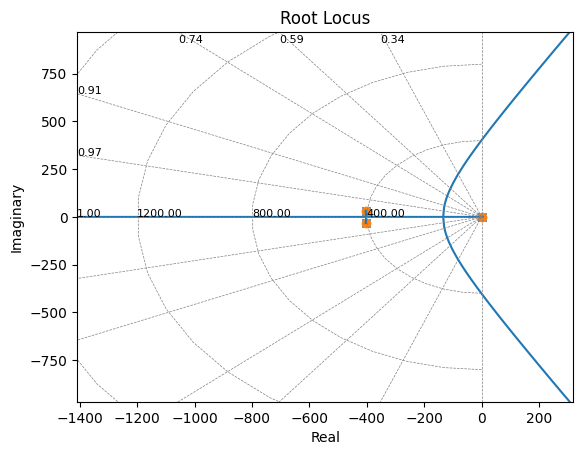

In [296]:
ctl.root_locus(G*C)
plt.show()

In [297]:
print(str(sympyFunction(G*C)))

(65735079.3982413*s**3 + 52950367875.4673*s**2 + 10679122015841.3*s - 20585155294754.8)/(159.178933054646*s**6 + 256241.794341985*s**5 + 154681372.205635*s**4 + 41366483530.2058*s**3 + 4068478968196.99*s**2 - 21435282646370.2*s + 27513185323973.4)
